In [76]:
import numpy as np
from scipy.spatial import distance
import ot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn import datasets
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.gaussian_process.kernels import RBF
from HOTDA import *
from sklearn.cluster import SpectralClustering
import numpy as np
import cv2,os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import glob
from matplotlib import pyplot
import seaborn as sns
import warnings
import pylab as pl
import numpy as np
import ot
from ot.datasets import make_data_classif
warnings.filterwarnings("ignore")


In [77]:
%matplotlib notebook


In [74]:
import pylab as pl
import numpy as np
import ot
from ot.datasets import make_data_classif

In [75]:
n = 20
sigma = 0.3
np.random.seed(1985)

p1 = .2
dec1 = [0, 2]

p2 = .9
dec2 = [0, -2]

pt = .4
dect = [4, 0]

xs1, ys1 = make_data_classif('2gauss_prop', n, nz=sigma, p=p1, bias=dec1)
xs2, ys2 = make_data_classif('2gauss_prop', n + 1, nz=sigma, p=p2, bias=dec2)
xt, yt = make_data_classif('2gauss_prop', n, nz=sigma, p=pt, bias=dect)

all_Xr = [xs1, xs2]
all_Yr = [ys1, ys2]

In [54]:
da = 1.5
def plot_ax(dec, name):
    pl.plot([dec[0], dec[0]], [dec[1] - da, dec[1] + da], 'k', alpha=0.5)
    pl.plot([dec[0] - da, dec[0] + da], [dec[1], dec[1]], 'k', alpha=0.5)
    pl.text(dec[0] - .5, dec[1] + 2, name)

In [55]:
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, metric='sqeuclidean')


def print_G(G, xs, ys, xt):
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            if G[i, j] > 5e-4:
                if ys[i]:
                    c = 'b'
                else:
                    c = 'r'
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], c, alpha=.2)

In [56]:
def print_G1(G, xs, xt):
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
                c = 'b'
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], c, alpha=.2)
def print_G2(G, xs, xt):
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
                c = 'r'
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], c, alpha=.2)
                                

In [57]:
def Source_processing(X,y):  
    S=[]
    a=[]
    mu=[]
    yc_source=[]
    classes=np.unique(y)
    k=len(classes)
    for i in range(k):
        C=X[y==i]
        yc_source=yc_source+y[y==i].tolist()
        w=np.ones(C.shape[0])/C.shape[0]
        S.append(C)
        a.append(w)
        mu.append(C.shape[0]/X.shape[0])
    mu=np.array(mu)
    return S,a,mu,yc_source
def Mapping(S,T,a,b,HOT):
    index=np.argmax(HOT,1)
    Transported_S=[]
    for i in range(len(S)):
        M=distance.cdist(S[i],T[index[i]], metric='sqeuclidean')
        OT=ot.bregman.sinkhorn_knopp(a[i],b[index[i]],M,reg=1)
        if i==0:
            OT0=ot.bregman.sinkhorn_knopp(a[i],b[index[i]],M,reg=0.1) 
        Transported_Source=np.linalg.inv(np.diag(OT.dot(np.ones(T[index[i]].shape[0])))).dot(OT).dot(T[index[i]])
        Transported_S.append(Transported_Source)
    return Transported_S,OT0,S[0],T[index[0]],OT,S[1],T[index[1]]

In [67]:
clustering = SpectralClustering(n_clusters=2, eigen_solver='arpack', assign_labels='kmeans',affinity="nearest_neighbors").fit(xt)
S,a,mu,yxs=Source_processing(xs1, ys1)
yxs=np.array(yxs).flatten().tolist()
T,b,nu,yxyys=Source_processing(xt,clustering.labels_)
W=np.zeros((len(S),len(T)))
OTl=[]
for i in range(len(S)):
    for j in range(len(T)):
        M=distance.cdist(S[i],T[j], metric='sqeuclidean')
        OT=ot.bregman.sinkhorn_knopp(a[i],b[j],M,reg=1e-1)
        OTl.append(OT)
        W[i][j] = np.trace(np.dot(OT.T,M))
HOT=ot.bregman.sinkhorn_knopp(mu,nu,W,reg=1e-1)
Transported_S,o,s0,t0,o1,s1,t1=Mapping(S,T,a,b,HOT)
X_Transported_S=Transported_S[0].tolist()+Transported_S[1].tolist()
y_Transported_S=np.array(yxs).flatten()
classifier = svm.SVC()
classifier.fit(X_Transported_S,y_Transported_S)


SVC()

<IPython.core.display.Javascript object>


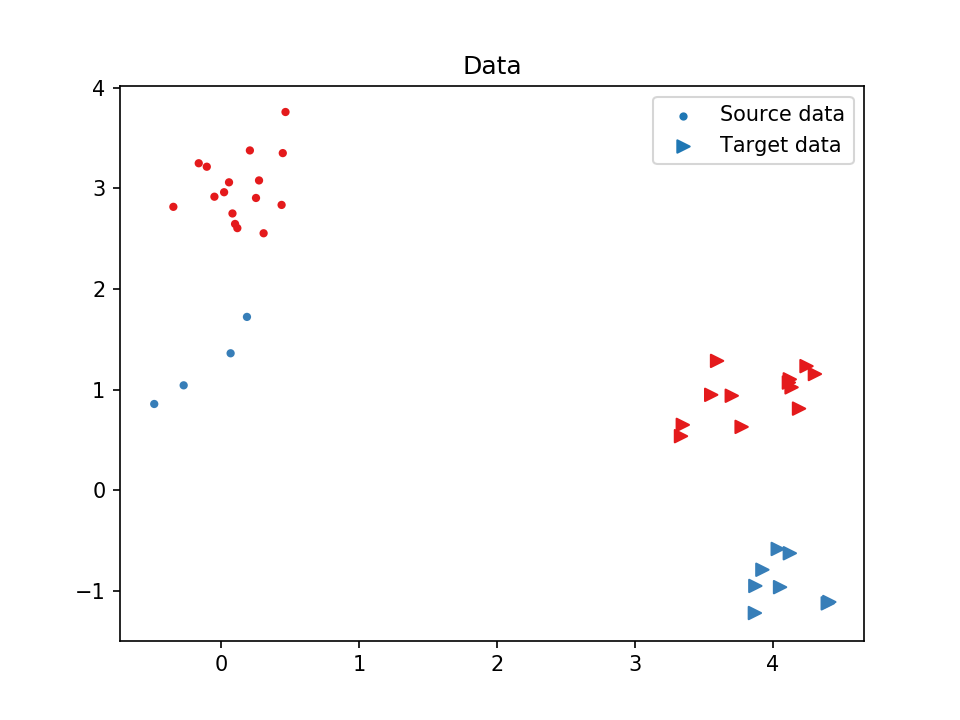

In [69]:
pl.figure()

pl.scatter(xs1[:, 0], xs1[:, 1], c=ys1, s=35, marker='.', cmap='Set1',label='Source data', vmax=9,
          )

pl.scatter(xt[:, 0], xt[:, 1], c=yt, s=35, marker='>', cmap='Set1',label='Target data', vmax=9,
           )
pl.title('Data')

pl.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


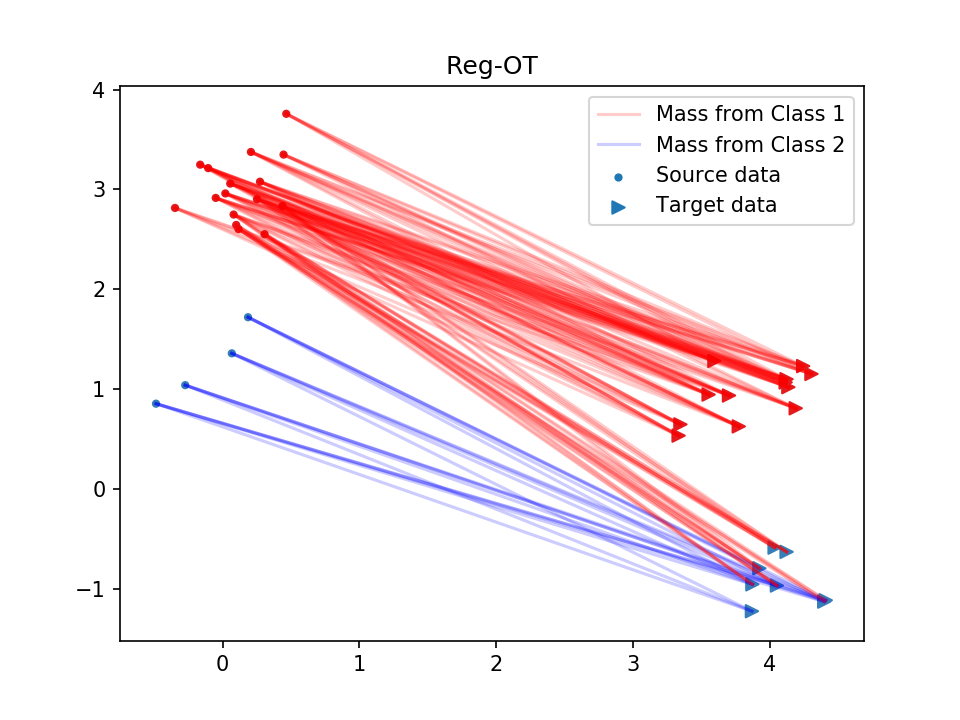

In [70]:
pl.figure()

print_G(ot_sinkhorn.fit(Xs=xs1, ys=ys1, Xt=xt).coupling_, xs1, ys1, xt)
pl.scatter(xs1[:, 0], xs1[:, 1], c=ys1, s=35, marker='.',label='Source data', cmap='Set1', vmax=9)
pl.scatter(xt[:, 0], xt[:, 1], c=yt, s=35, marker='>', cmap='Set1',label='Target data', vmax=9)
pl.title('Reg-OT')
pl.plot([], [], 'r', alpha=.2, label='Mass from Class 1')
pl.plot([], [], 'b', alpha=.2, label='Mass from Class 2')
pl.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


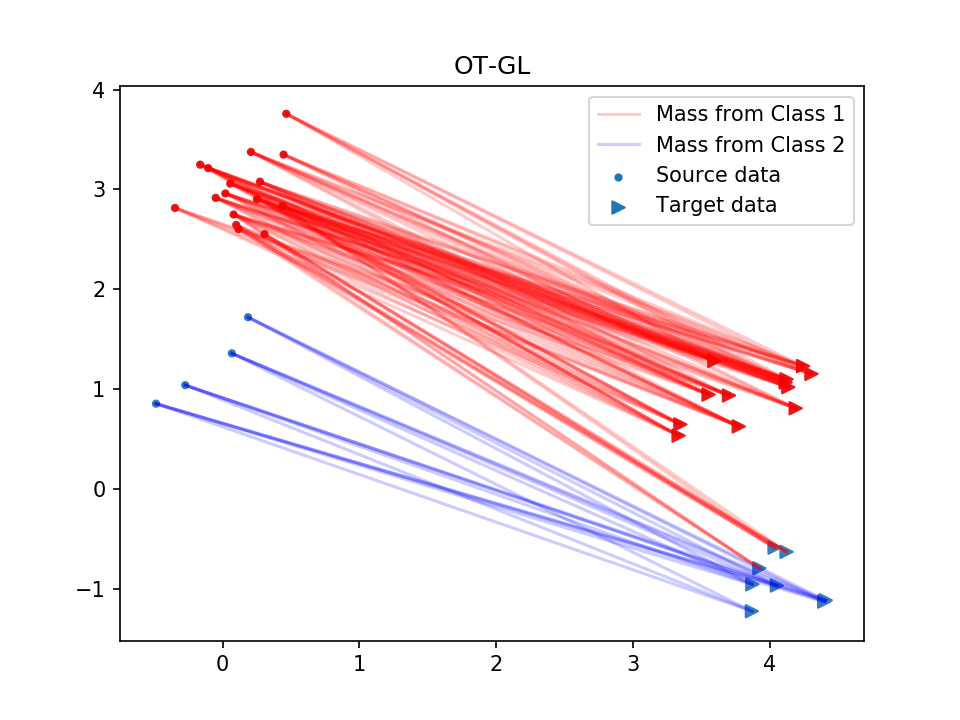

In [71]:
pl.figure()

ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
print_G(ot_lpl1.fit(Xs=xs1, ys=ys1, Xt=xt).coupling_, xs1, ys1, xt)
pl.scatter(xs1[:, 0], xs1[:, 1], c=ys1, s=35, marker='.',label='Source data', cmap='Set1', vmax=9)
pl.scatter(xt[:, 0], xt[:, 1], c=yt, s=35, marker='>',label='Target data', cmap='Set1', vmax=9)
pl.title('OT-GL')
pl.plot([], [], 'r', alpha=.2, label='Mass from Class 1')
pl.plot([], [], 'b', alpha=.2, label='Mass from Class 2')
pl.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


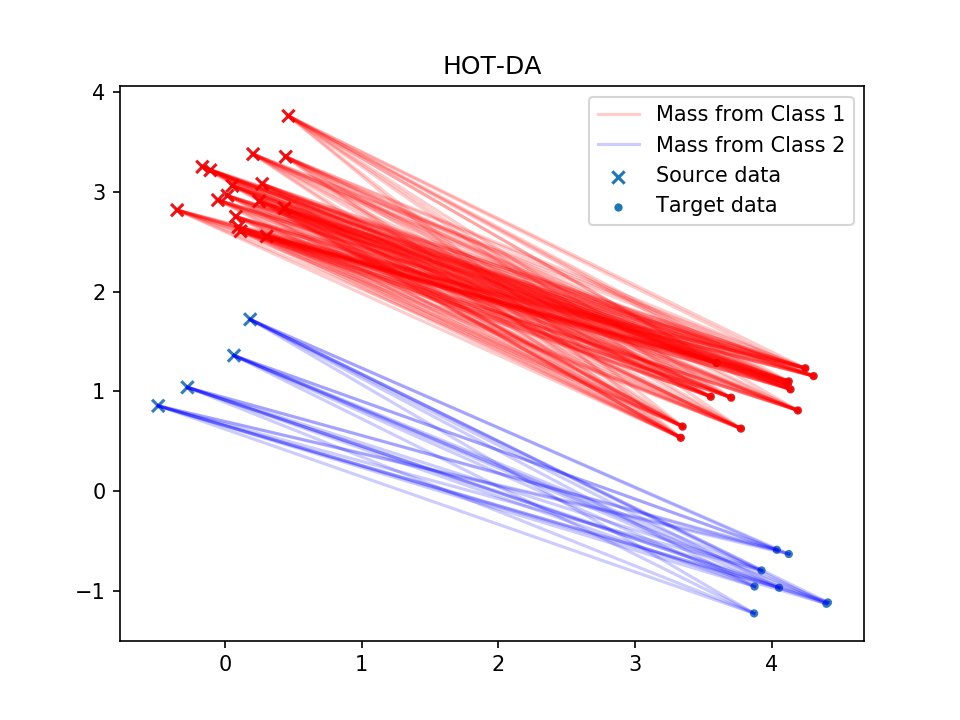

In [72]:
fig = pl.figure()
pl.clf()

print_G2(o, s0, t0)
print_G1(o1, s1, t1)
pl.scatter(xs1[:, 0], xs1[:, 1], c=ys1, s=35, marker='x', cmap='Set1',label='Source data', vmax=9)
pl.scatter(xt[:, 0], xt[:, 1], c=yt, s=35, marker='.', cmap='Set1',label='Target data', vmax=9)
pl.plot([], [], 'r', alpha=.2, label='Mass from Class 1')
pl.plot([], [], 'b', alpha=.2, label='Mass from Class 2')

pl.title('HOT-DA')

pl.legend(loc=0)